In [1]:
#Get tide height for every image in Landsat collections? Might be trickiest step
#Plot: percentage of pixels inundated over time, within flux tower footprint (BUT will depend on tidal height)

In [2]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

In [3]:
import glob
import pandas as pd
##PC:
path = r'C:/Users/arj26323/Documents/Data/flats/Tide data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df

,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m)
0,1985/01/02,00:00,0.891,-,1.007
1,1985/01/02,01:00,0.540,-,0.681
2,1985/01/02,02:00,0.275,-,0.418
3,1985/01/02,03:00,0.187,-,0.354
4,1985/01/02,04:00,0.332,-,0.507
...,...,...,...,...,...
350635,1985/01/01,19:00,1.456,-,1.65
350636,1985/01/01,20:00,1.658,-,1.763
350637,1985/01/01,21:00,1.693,-,1.695
350638,1985/01/01,22:00,1.547,-,1.555


In [4]:
import seaborn as sns

dims = (11.7, 8.27)
# fig, ax = plt.subplots(figsize=dims)
# g = sns.lineplot(ax = ax, x = "Date", y = "Predicted (m)", color = "b", data = df)


In [5]:
df2 = df.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])


time_mask = (df2['Time (GMT)'].dt.hour == 16)

df_time = df2[time_mask]

df_time

C:\Users\arj26323\AppData\Local\Temp\ipykernel_9652\4110901417.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])


,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m),DOY
16,1985/01/02,2023-09-19 16:00:00,0.340,-,0.479,1985-01-02
40,1985/01/03,2023-09-19 16:00:00,0.275,-,0.406,1985-01-03
64,1985/01/04,2023-09-19 16:00:00,0.374,-,0.458,1985-01-04
88,1985/01/05,2023-09-19 16:00:00,0.620,-,0.543,1985-01-05
112,1985/01/06,2023-09-19 16:00:00,0.967,-,1.162,1985-01-06
...,...,...,...,...,...,...
350536,1984/12/28,2023-09-19 16:00:00,1.759,-,1.83,1984-12-28
350560,1984/12/29,2023-09-19 16:00:00,1.466,-,1.449,1984-12-29
350584,1984/12/30,2023-09-19 16:00:00,1.148,-,1.104,1984-12-30
350608,1984/12/31,2023-09-19 16:00:00,0.835,-,0.927,1984-12-31


In [6]:
ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

In [7]:
#Note 1/18/23: Flux tower footprint (fluxproper) OR expanded flux area (fluxdiss) OR all gce (gce_clip)

gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_sapelodissolve.shp'

gce_fluxdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_fluxdissolve.shp'

gce_fluxproper = 'F:/Wetlands shapefiles/GCE flux tower/2014-climatology.shp'

gce_expandedflux = 'F:/Wetlands shapefiles/GCE flux tower/expanded_flux.shp' ## Added 9/18/23 - fix shapefile problems!

flux_ga = geemap.shp_to_ee(gce_expandedflux)

## DEM
elevation = ee.Image('USGS/3DEP/10m').clip(flux_ga) ##This is 1/3 arc second, or 10 m.

In [8]:
Map.addLayer(flux_ga)
Map

Map(center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [9]:
#Pixel counts of each region:
image = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711')
x = image.reduceRegion(geometry=flux_ga, reducer=ee.Reducer.count(), scale=30)
x.getInfo()

{'QA_PIXEL': 1946,
 'QA_RADSAT': 1946,
 'SR_ATMOS_OPACITY': 1946,
 'SR_B1': 1946,
 'SR_B2': 1946,
 'SR_B3': 1946,
 'SR_B4': 1946,
 'SR_B5': 1946,
 'SR_B7': 1946,
 'SR_CLOUD_QA': 1453,
 'ST_ATRAN': 1946,
 'ST_B6': 1946,
 'ST_CDIST': 1946,
 'ST_DRAD': 1946,
 'ST_EMIS': 1946,
 'ST_EMSD': 1946,
 'ST_QA': 1946,
 'ST_TRAD': 1946,
 'ST_URAD': 1946}

In [10]:
##FLATS

#12/08/22 - add calibrated flats to images
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))


#NOTE: above is 7-9 calibration; below is 8-9 calibration

# def addFLATSL9(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(1.51 + 12.5*(0.945*(RED-SWIR)/(RED+SWIR) - 0.055) - 41.2*(0.974* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.0005)))', {
#             'SWIR': image.select('SR_B6'),
#             'NIR': image.select('SR_B5'),
#             'RED': image.select('SR_B4'),
#             'BLUE': image.select('SR_B2')
#         })
    
#     return image.addBands(flats.rename('flats'))


##NOTE: original flats:

# def addFLATS(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
#             'SWIR': image.select('SR_B6'),
#             'RED': image.select('SR_B4'),
#             'GREEN': image.select('SR_B3')
#         })
    
#     return image.addBands(flats.rename('flats'))

# def addFLATSL5(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
#             'SWIR': image.select('SR_B5'),
#             'RED': image.select('SR_B3'),
#             'GREEN': image.select('SR_B2')
#         })
    
#     return image.addBands(flats.rename('flats'))

#NDWI
def addndwi(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

def addndwiL5(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

#PHENO
def addpheno(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(pheno.rename('pheno'))

def addphenoL5(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(pheno.rename('pheno'))

#NIRv
def addnirv(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(nirv.rename('nirv'))

def addnirvL5(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4')
        })
    
    return image.addBands(nirv.rename('nirv'))

#NDVI
def addndvi(image):
    ndvi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addndviL5(image):
    ndvi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

#EVI
def addeviL5(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(evi.rename('evi'))

def addevi(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(evi.rename('evi'))

#12/01/22
#VARI
def addvariL5(image):
    vari = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED-BLUE)', {
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(vari.rename('vari'))

def addvari(image):
    vari = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED-BLUE)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(vari.rename('vari'))


#GLI
def addgliL5(image):
    gli = ee.Image(0).expression(
        '((GREEN-RED) + (GREEN-BLUE))/(2*GREEN+RED+BLUE)', {
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(gli.rename('gli'))

def addgli(image):
    gli = ee.Image(0).expression(
        '((GREEN-RED) + (GREEN-BLUE))/(2*GREEN+RED+BLUE)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(gli.rename('gli'))

In [11]:
# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)


#Function to add elevation

def add_elevation(image):
    elevation_band = elevation.rename('elevation')
    return image.addBands(elevation_band)

In [12]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [13]:
#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band).map(add_elevation)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band).map(add_elevation)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band).map(add_elevation)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band).map(add_elevation)

In [14]:
#Percentage of pixels in study area flagged

#ee.reducer.count pixels that are above 0.2, divide by NUMBER OF PIXELS TOTAL (not always 71 due to masking).
#Then do for larger scene? Then add in tide (HOW)

def calculate_percentage(image):
    # Select the "flats" band
    flats_band = image.select('flats')
    
    # Create a binary mask where pixels with values above 0.2 are set to 1, others to 0
    threshold_mask = flats_band.gt(0.2)
    
    # Calculate the total count of pixels within the area defined by flux_ga - DONE FIRST, BEFORE MASK
    total_pixel_count = image.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=flux_ga,
        scale=30  # Adjust scale as needed, e.g., 30 meters for Landsat
    ).get('flats')
      
    # Mask the image with the threshold mask - DONE AFTER FIRST REDUCE REGION
    image2 = image.updateMask(threshold_mask)
    
    # Calculate the count of pixels above 0.2 within the area defined by flux_ga
    above_threshold_count = image2.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=flux_ga,
        scale=30  # Adjust scale as needed
    ).get('flats')
    
    # Calculate the percentage
    percentage = ee.Number(above_threshold_count).divide(total_pixel_count).multiply(100)
    
    return image.set('percentage_flood', percentage).set('total_pixel_count', total_pixel_count)


# Map the function over the image collection
perflood_l8 = l8_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l8.aggregate_array('system:time_start')
percentages = perflood_l8.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l8.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df8 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df8['Date'] = pd.to_datetime(df8['Date'], unit='ms')

# Sort the DataFrame by Date
df8 = df8.sort_values(by='Date')

In [15]:
list_l8 = perflood_l8.toList(perflood_l8.size())

x = ee.Image(list_l8.get(0))

vis_param = {'min': 0, 
             'max': 0.5, 
             'bands': ['SR_B5', 'SR_B4', 'SR_B3'], 
             'gamma': 1.5}

# Map.addLayer(x, vis_param, 'SR')

# Map.addLayer(x, {'bands': ['flats'], 'min': 0, 'max': 1}, 'FLATS')

# Map.addLayer(flux_ga)


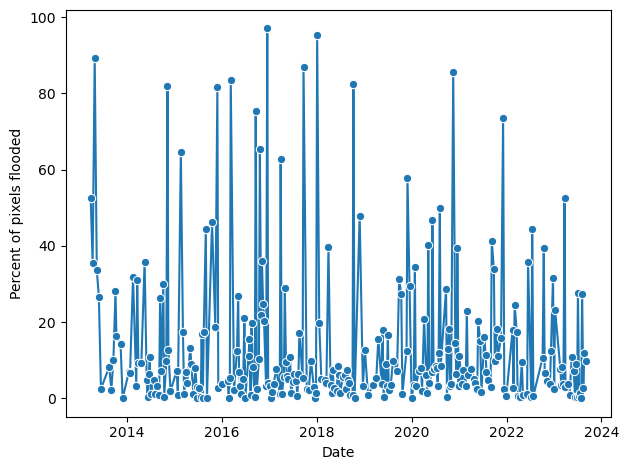

In [16]:
dfw = df8[df8['Total_Pixel_Count'] >= 30] #Filter out low pixel-scenes

import seaborn as sns
ax = sns.lineplot(
    x="Date",
    y="Percentage",
    legend=False,
    marker = 'o',
    data=dfw
)

plt.ylabel("Percent of pixels flooded")

plt.tight_layout()


In [52]:
# dfw

In [51]:
top_20 = df8.nlargest(20, 'Percentage')

# print(top_20) #CHECK to see if high percentage just caused by low total number of pixels due to cloud maskig
#May not be representative if clouds cover much of scene

#Earlier - way of filtering out low-pixel scenes

In [19]:
# Landsat 5
perflood_l5 = l5_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l5.aggregate_array('system:time_start')
percentages = perflood_l5.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l5.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df5 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df5['Date'] = pd.to_datetime(df5['Date'], unit='ms')

# Sort the DataFrame by Date
df5 = df5.sort_values(by='Date')


In [20]:
# Landsat 7
perflood_l7 = l7_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l7.aggregate_array('system:time_start')
percentages = perflood_l7.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l7.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df7 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df7['Date'] = pd.to_datetime(df7['Date'], unit='ms')

# Sort the DataFrame by Date
df7 = df7.sort_values(by='Date')

In [21]:
#Landsat 9
perflood_l9 = l9_col.map(calculate_percentage)

# Get the list of dates and percentages
dates = perflood_l9.aggregate_array('system:time_start')
percentages = perflood_l9.aggregate_array('percentage_flood')
total_pixel_counts = perflood_l9.aggregate_array('total_pixel_count')

# Convert the dates, percentages, and total pixel counts to lists
dates_list = dates.getInfo()
percentages_list = percentages.getInfo()
total_pixel_counts_list = total_pixel_counts.getInfo()

# Create a DataFrame
df9 = pd.DataFrame({'Date': dates_list, 'Percentage': percentages_list, 'Total_Pixel_Count': total_pixel_counts_list})

# Convert the Date column to datetime
df9['Date'] = pd.to_datetime(df9['Date'], unit='ms')

# Sort the DataFrame by Date
df9 = df9.sort_values(by='Date')

In [22]:
df = pd.concat([df5,df7,df8,df9], axis=0)
df = df.reset_index(drop=True)

df['DOY'] = df['Date'].dt.strftime('%Y-%m-%d')
df['DOY'] = pd.to_datetime(df['DOY'])
df

# print(df.dtypes)

,Date,Percentage,Total_Pixel_Count,DOY
0,1984-04-12 15:21:47.367,7.258065,248,1984-04-12
1,1984-04-19 15:27:58.365,38.437821,1946,1984-04-19
2,1984-05-05 15:28:05.134,4.059609,1946,1984-05-05
3,1984-05-14 15:22:12.295,9.866393,1946,1984-05-14
4,1984-05-21 15:28:35.468,3.969194,1688,1984-05-21
...,...,...,...,...
2367,2023-08-13 16:00:34.545,36.363636,66,2023-08-13
2368,2023-08-22 15:54:28.019,0.363636,275,2023-08-22
2369,2023-08-29 16:00:43.797,0.000000,0,2023-08-29
2370,2023-09-07 15:54:38.470,11.918275,1762,2023-09-07


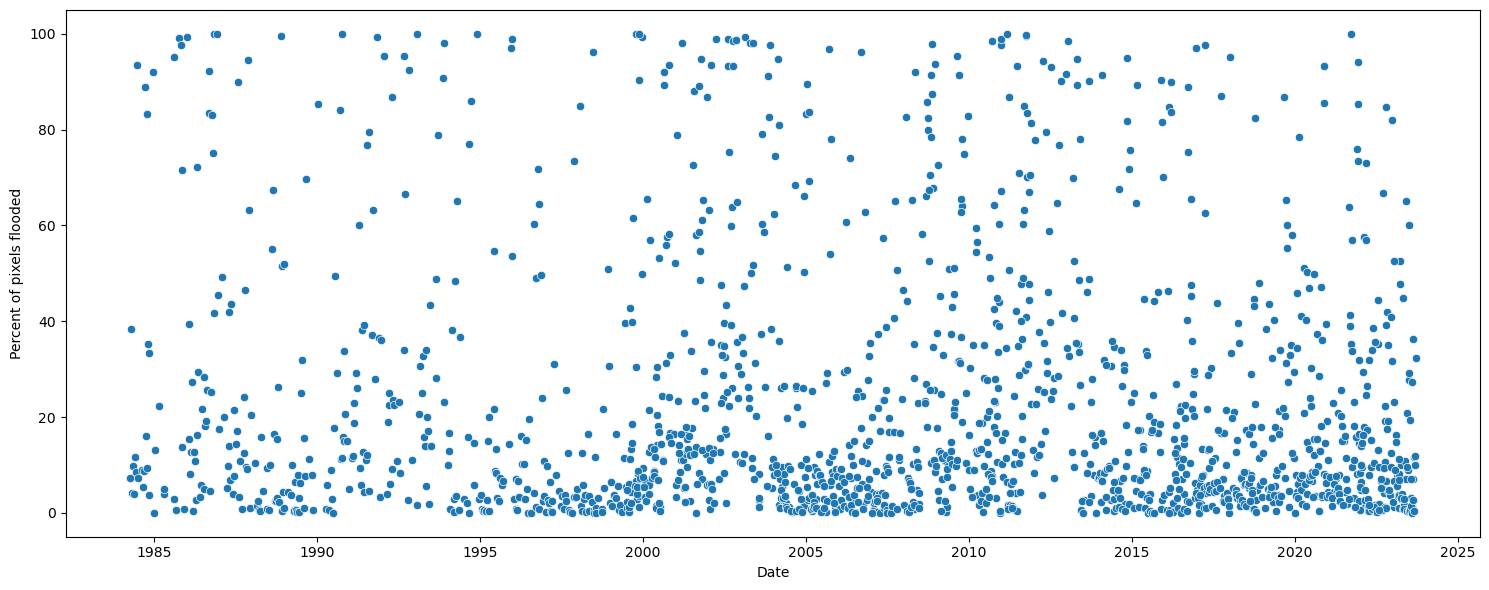

In [23]:
df_all = df[df['Total_Pixel_Count'] >= 30] #Filter out low pixel-scenes

plt.figure(figsize=(15, 6))


import seaborn as sns
ax = sns.scatterplot(
    x="Date",
    y="Percentage",
    legend=False,
    marker = 'o',
    data=df_all
)

plt.ylabel("Percent of pixels flooded")


plt.tight_layout()

In [24]:
df_all

,Date,Percentage,Total_Pixel_Count,DOY
0,1984-04-12 15:21:47.367,7.258065,248,1984-04-12
1,1984-04-19 15:27:58.365,38.437821,1946,1984-04-19
2,1984-05-05 15:28:05.134,4.059609,1946,1984-05-05
3,1984-05-14 15:22:12.295,9.866393,1946,1984-05-14
4,1984-05-21 15:28:35.468,3.969194,1688,1984-05-21
...,...,...,...,...
2365,2023-07-21 15:54:13.029,7.142857,1946,2023-07-21
2367,2023-08-13 16:00:34.545,36.363636,66,2023-08-13
2368,2023-08-22 15:54:28.019,0.363636,275,2023-08-22
2370,2023-09-07 15:54:38.470,11.918275,1762,2023-09-07


In [25]:
df_combined = pd.merge(df, df_time, on = 'DOY')
df_combined['Date'] = df_combined['Date_x']
df_combined

,Date_x,Percentage,Total_Pixel_Count,DOY,Date_y,Time (GMT),Predicted (m),Preliminary (m),Verified (m),Date
0,1984-04-12 15:21:47.367,7.258065,248,1984-04-12,1984/04/12,2023-09-19 16:00:00,-0.025,-,0.126,1984-04-12 15:21:47.367
1,1984-04-19 15:27:58.365,38.437821,1946,1984-04-19,1984/04/19,2023-09-19 16:00:00,2.053,-,2.009,1984-04-19 15:27:58.365
2,1984-05-05 15:28:05.134,4.059609,1946,1984-05-05,1984/05/05,2023-09-19 16:00:00,1.853,-,1.848,1984-05-05 15:28:05.134
3,1984-05-14 15:22:12.295,9.866393,1946,1984-05-14,1984/05/14,2023-09-19 16:00:00,0.642,-,0.257,1984-05-14 15:22:12.295
4,1984-05-21 15:28:35.468,3.969194,1688,1984-05-21,1984/05/21,2023-09-19 16:00:00,1.473,-,1.397,1984-05-21 15:28:35.468
...,...,...,...,...,...,...,...,...,...,...
2367,2023-08-13 16:00:34.545,36.363636,66,2023-08-13,2023/08/13,2023-09-19 16:00:00,0.277,-,0.273,2023-08-13 16:00:34.545
2368,2023-08-22 15:54:28.019,0.363636,275,2023-08-22,2023/08/22,2023-09-19 16:00:00,2.054,-,2.056,2023-08-22 15:54:28.019
2369,2023-08-29 16:00:43.797,0.000000,0,2023-08-29,2023/08/29,2023-09-19 16:00:00,0.211,-,0.488,2023-08-29 16:00:43.797
2370,2023-09-07 15:54:38.470,11.918275,1762,2023-09-07,2023/09/07,2023-09-19 16:00:00,1.366,-,-,2023-09-07 15:54:38.470


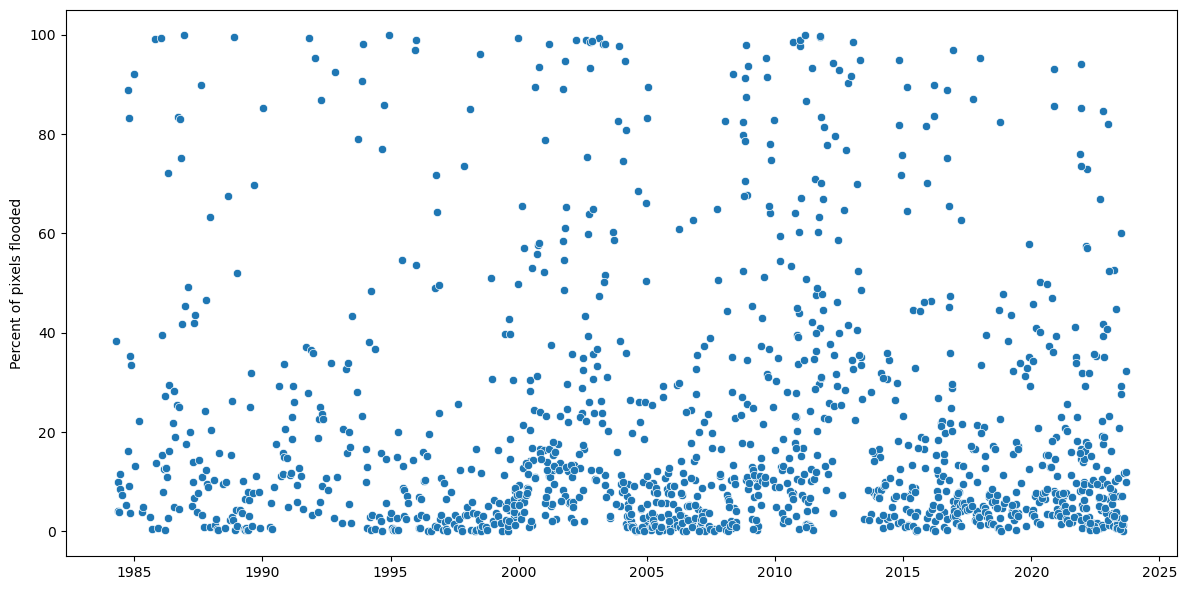

In [26]:
df_ultra = df_combined[df_combined['Total_Pixel_Count'] >= 970] #Filter out low pixel-scenes, approx. half (CHECK PIX COUNT)

plt.figure(figsize=(12, 6))

import seaborn as sns
ax = sns.scatterplot(
    x="Date",
    y="Percentage",
    legend=False,
    marker = 'o',
    data=df_ultra
)

plt.ylabel("Percent of pixels flooded")
plt.xlabel("")

plt.tight_layout()

# plt.savefig('fluxproper_flooding.png', bbox_inches='tight', dpi = 300)

In [27]:
# sns.lineplot(x='Date', y='Percentage', data=df_ultra, hue='Verified (m)', ci=None)
# plt.xlabel('Year')
# plt.ylabel('Percent Flooded')
# plt.title('Percent Flooded ~ Year (Tide Height)')
# plt.show()


# df_ultra['Verified (m)'] = df_ultra['Verified (m)'].replace('-', float('nan'))

# df_ultra['Verified (m)'] = df_ultra['Verified (m)'].astype('float')

# df_ultra.dropna()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df_ultra['Percentage'])


In [28]:
# import statsmodels.api as sm

# Add a constant term to the DataFrame for the intercept
df_x = df_ultra.copy()

df_x['Verified (m)'] = df_x['Verified (m)'].replace('-', float('nan')).astype('float')

df_x = df_x.dropna()

df_x['Date'] = pd.to_datetime(df_x['Date'])

df_x['intercept'] = 1

# df_x['Trans_per'] =

# # Create a linear regression model
# model = sm.OLS(df_x['Percentage'], df_x[['Date', 'Verified (m)', 'intercept']])

# # Fit the model
# results = model.fit()

# # Print the summary statistics
# print(results.summary())


In [29]:
# df_x.dtypes

In [30]:
# df_x.isnull().sum()


In [31]:
# df_x['Verified (m)'].describe()

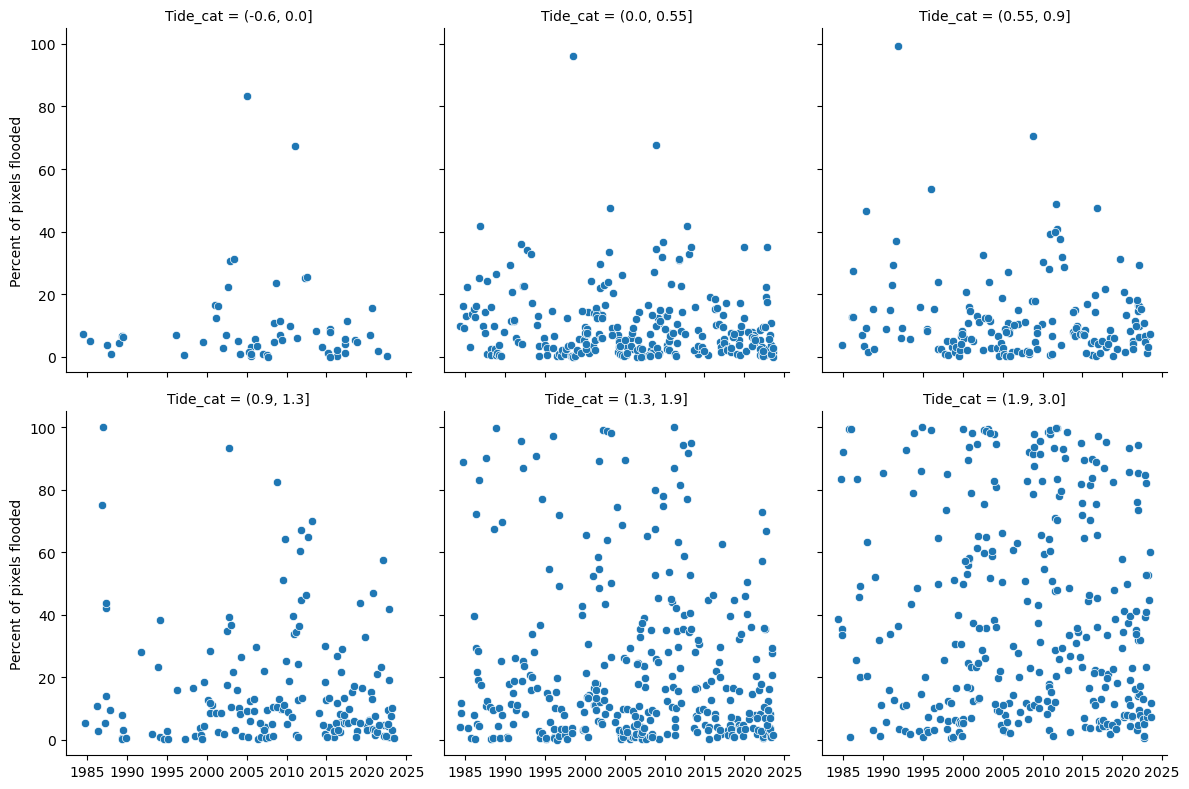

In [32]:
# Create a facet grid for 'Verified (m)' categories

df_x['Tide_cat'] = pd.cut(df_x['Verified (m)'], bins = [-0.6, 0, 0.55, 0.9, 1.3, 1.9, 3])

g = sns.FacetGrid(df_x, col="Tide_cat", col_wrap=3, height=4)
g.map(sns.scatterplot, "Date", "Percentage", marker='o', legend=False)

# Set axis labels and adjust layout
g.set_axis_labels("", "Percent of pixels flooded")
g.tight_layout()
plt.show()

# g.savefig('flux_gce_x.png', bbox_inches='tight', dpi = 300)

In [96]:
#DEM
region = flux_ga
dem = elevation
# dem_df = geemap.ee_to_pandas(dem.addBands(dem.pixelLonLat()).sampleRegions(collection = region, scale = 10, geometries = True))

# print(dem_df)

In [34]:
# dem_df['elevation'].hist(bins = 55)

In [41]:
# elevation = dem.clip(flux_ga)

# Define the elevation range
elevation_range = [0, 0.79]
elevation_range2 = [0.79, 0.87]
elevation_range3 = [0.87, 0.94]
elevation_range4 = [0.94, 1.3]


# Create a mask for the elevation range
elevation_mask = elevation.gte(elevation_range[0]).And(elevation.lt(elevation_range[1]))
elevation_mask2 = elevation.gte(elevation_range2[0]).And(elevation.lt(elevation_range2[1]))
elevation_mask3 = elevation.gte(elevation_range3[0]).And(elevation.lt(elevation_range3[1]))
elevation_mask4 = elevation.gte(elevation_range4[0]).And(elevation.lt(elevation_range4[1]))


# Mask the DEM to retain only the specified elevation range
elevation_low = elevation.updateMask(elevation_mask)
elevation_medlow = elevation.updateMask(elevation_mask2)
elevation_medhigh = elevation.updateMask(elevation_mask3)
elevation_high = elevation.updateMask(elevation_mask4)

# Add the elevation range raster to the map for visualization
Map.addLayer(elevation_low, {
    'min': elevation_range[0],
    'max': elevation_range[1],
    'palette': ['blue', 'green', 'yellow', 'red']  # Adjust the palette as needed
}, 'Low')

Map.addLayer(elevation_medlow, {
    'min': elevation_range[0],
    'max': elevation_range[1],
    'palette': ['blue', 'green', 'yellow', 'red']  # Adjust the palette as needed
}, 'medlow')

Map.addLayer(elevation_medhigh, {
    'min': elevation_range[0],
    'max': elevation_range[1],
    'palette': ['blue', 'green', 'yellow', 'red']  # Adjust the palette as needed
}, 'medhigh')

Map.addLayer(elevation_high, {
    'min': elevation_range[0],
    'max': elevation_range[1],
    'palette': ['blue', 'green', 'yellow', 'red']  # Adjust the palette as needed
}, 'High')

# Display the map
Map

Map(bottom=107150.0, center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent…

In [47]:
# Map.addLayer(x, vis_param, 'SR')

# xm = x.mask(elevation_low)

# Map.addLayer(xm, vis_param, 'mask')

# Map

In [127]:
#MASKING DIFFERENT ELEVATIONS - note: recycled variables, be careful!
#Also note: RESAMPLES LANDSAT PIXELS TO 10 M, AFFECTING PIXEL COUNT

elev = elevation_low #CHANGE BASED ON WHAT ELEVATION RANGE YOU WANT TO SEE

el8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band).map(add_elevation).map(lambda image: image.mask(elev))

el7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band).map(add_elevation).map(lambda image: image.mask(elev))

el5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band).map(add_elevation).map(lambda image: image.mask(elev))

el9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band).map(add_elevation).map(lambda image: image.mask(elev))

# l8
eperflood_l8 = el8_col.map(calculate_percentage)
edates = eperflood_l8.aggregate_array('system:time_start')
epercentages = eperflood_l8.aggregate_array('percentage_flood')
etotal_pixel_counts = eperflood_l8.aggregate_array('total_pixel_count')
edates_list = edates.getInfo()
epercentages_list = epercentages.getInfo()
etotal_pixel_counts_list = etotal_pixel_counts.getInfo()
edf8 = pd.DataFrame({'Date': edates_list, 'Percentage': epercentages_list, 'Total_Pixel_Count': etotal_pixel_counts_list})
edf8['Date'] = pd.to_datetime(edf8['Date'], unit='ms')
edf8 = edf8.sort_values(by='Date')

#l5
eperflood_l5 = el5_col.map(calculate_percentage)
edates = eperflood_l5.aggregate_array('system:time_start')
epercentages = eperflood_l5.aggregate_array('percentage_flood')
etotal_pixel_counts = eperflood_l5.aggregate_array('total_pixel_count')
edates_list = edates.getInfo()
epercentages_list = epercentages.getInfo()
etotal_pixel_counts_list = etotal_pixel_counts.getInfo()
edf5 = pd.DataFrame({'Date': edates_list, 'Percentage': epercentages_list, 'Total_Pixel_Count': etotal_pixel_counts_list})
edf5['Date'] = pd.to_datetime(edf5['Date'], unit='ms')
edf5 = edf5.sort_values(by='Date')

#l7
eperflood_l7 = el7_col.map(calculate_percentage)
edates = eperflood_l7.aggregate_array('system:time_start')
epercentages = eperflood_l7.aggregate_array('percentage_flood')
etotal_pixel_counts = eperflood_l7.aggregate_array('total_pixel_count')
edates_list = edates.getInfo()
epercentages_list = epercentages.getInfo()
etotal_pixel_counts_list = etotal_pixel_counts.getInfo()
edf7 = pd.DataFrame({'Date': edates_list, 'Percentage': epercentages_list, 'Total_Pixel_Count': etotal_pixel_counts_list})
edf7['Date'] = pd.to_datetime(edf7['Date'], unit='ms')
edf7 = edf7.sort_values(by='Date')

#l9
eperflood_l9 = el9_col.map(calculate_percentage)
edates = eperflood_l9.aggregate_array('system:time_start')
epercentages = eperflood_l9.aggregate_array('percentage_flood')
etotal_pixel_counts = eperflood_l9.aggregate_array('total_pixel_count')
edates_list = edates.getInfo()
epercentages_list = epercentages.getInfo()
etotal_pixel_counts_list = etotal_pixel_counts.getInfo()
edf9 = pd.DataFrame({'Date': edates_list, 'Percentage': epercentages_list, 'Total_Pixel_Count': etotal_pixel_counts_list})
edf9['Date'] = pd.to_datetime(edf9['Date'], unit='ms')
edf9 = edf9.sort_values(by='Date')

edf = pd.concat([edf5,edf7,edf8,edf9], axis=0)
edf = edf.reset_index(drop=True)

edf['DOY'] = edf['Date'].dt.strftime('%Y-%m-%d')
edf['DOY'] = pd.to_datetime(edf['DOY'])
edf

,Date,Percentage,Total_Pixel_Count,DOY
0,1984-04-12 15:21:47.367,1.664533,781,1984-04-12
1,1984-04-19 15:27:58.365,43.405890,781,1984-04-19
2,1984-05-05 15:28:05.134,4.481434,781,1984-05-05
3,1984-05-14 15:22:12.295,11.907810,781,1984-05-14
4,1984-05-21 15:28:35.468,3.072983,781,1984-05-21
...,...,...,...,...
2367,2023-08-13 16:00:34.545,1.280410,781,2023-08-13
2368,2023-08-22 15:54:28.019,0.128041,781,2023-08-22
2369,2023-08-29 16:00:43.797,0.000000,781,2023-08-29
2370,2023-09-07 15:54:38.470,7.810499,781,2023-09-07


In [128]:
edf_combined = pd.merge(edf, df_time, on = 'DOY')
edf_combined['Date'] = edf_combined['Date_x']
edf_combined

,Date_x,Percentage,Total_Pixel_Count,DOY,Date_y,Time (GMT),Predicted (m),Preliminary (m),Verified (m),Date
0,1984-04-12 15:21:47.367,1.664533,781,1984-04-12,1984/04/12,2023-09-19 16:00:00,-0.025,-,0.126,1984-04-12 15:21:47.367
1,1984-04-19 15:27:58.365,43.405890,781,1984-04-19,1984/04/19,2023-09-19 16:00:00,2.053,-,2.009,1984-04-19 15:27:58.365
2,1984-05-05 15:28:05.134,4.481434,781,1984-05-05,1984/05/05,2023-09-19 16:00:00,1.853,-,1.848,1984-05-05 15:28:05.134
3,1984-05-14 15:22:12.295,11.907810,781,1984-05-14,1984/05/14,2023-09-19 16:00:00,0.642,-,0.257,1984-05-14 15:22:12.295
4,1984-05-21 15:28:35.468,3.072983,781,1984-05-21,1984/05/21,2023-09-19 16:00:00,1.473,-,1.397,1984-05-21 15:28:35.468
...,...,...,...,...,...,...,...,...,...,...
2367,2023-08-13 16:00:34.545,1.280410,781,2023-08-13,2023/08/13,2023-09-19 16:00:00,0.277,-,0.273,2023-08-13 16:00:34.545
2368,2023-08-22 15:54:28.019,0.128041,781,2023-08-22,2023/08/22,2023-09-19 16:00:00,2.054,-,2.056,2023-08-22 15:54:28.019
2369,2023-08-29 16:00:43.797,0.000000,781,2023-08-29,2023/08/29,2023-09-19 16:00:00,0.211,-,0.488,2023-08-29 16:00:43.797
2370,2023-09-07 15:54:38.470,7.810499,781,2023-09-07,2023/09/07,2023-09-19 16:00:00,1.366,-,-,2023-09-07 15:54:38.470


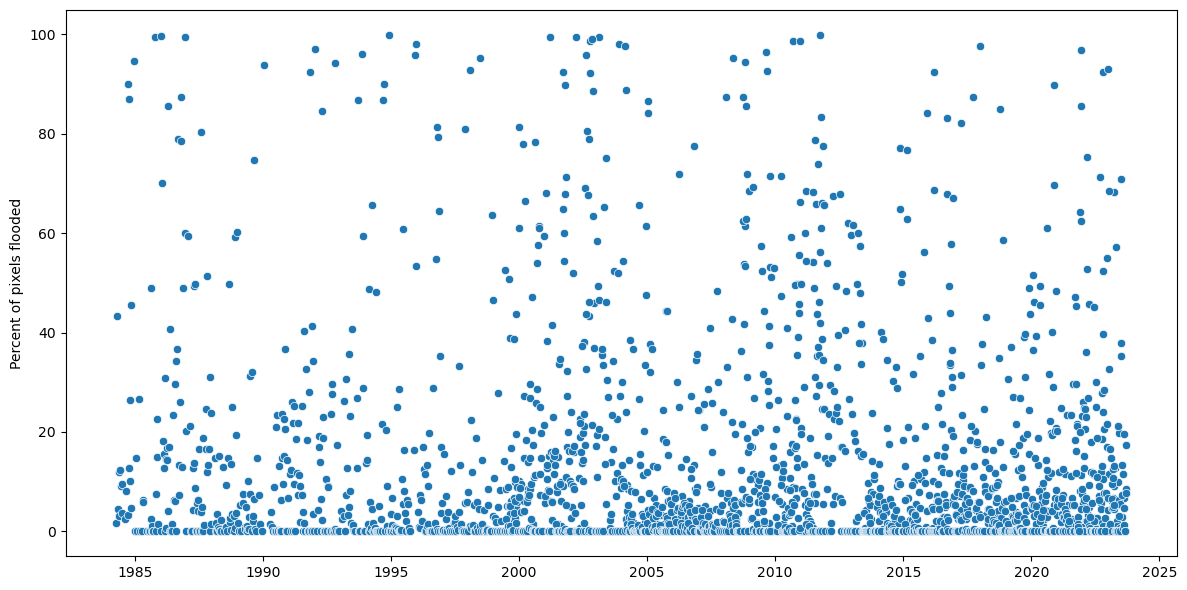

In [129]:
edf_ultra = edf_combined[edf_combined['Total_Pixel_Count'] >= 30]

plt.figure(figsize=(12, 6))

import seaborn as sns
ax = sns.scatterplot(
    x="Date",
    y="Percentage",
    legend=False,
    marker = 'o',
    data=edf_ultra
)

plt.ylabel("Percent of pixels flooded")
plt.xlabel("")

plt.tight_layout()

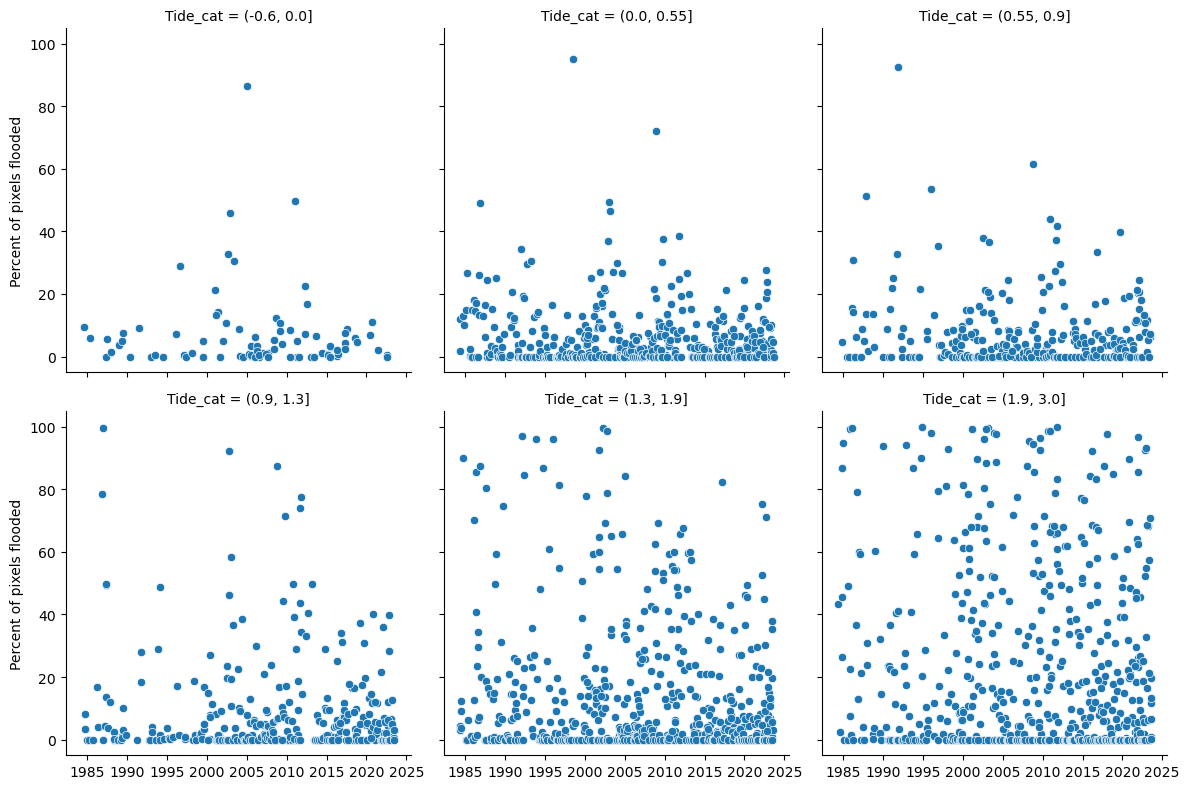

In [130]:
# Add a constant term to the DataFrame for the intercept
edf_x = edf_ultra.copy()

edf_x['Verified (m)'] = edf_x['Verified (m)'].replace('-', float('nan')).astype('float')

edf_x = edf_x.dropna()

edf_x['Date'] = pd.to_datetime(edf_x['Date'])

edf_x['intercept'] = 1

import math
# edf_x['log_percent'] = math.log(edf_x['Percentage'])

# Create a facet grid for 'Verified (m)' categories

edf_x['Tide_cat'] = pd.cut(edf_x['Verified (m)'], bins = [-0.6, 0, 0.55, 0.9, 1.3, 1.9, 3])

g = sns.FacetGrid(edf_x, col="Tide_cat", col_wrap=3, height=4)
g.map(sns.scatterplot, "Date", "Percentage", marker='o', legend=False)

# Set axis labels and adjust layout
g.set_axis_labels("", "Percent of pixels flooded")
g.tight_layout()
plt.show()

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# g.savefig('high_elev.png', bbox_inches='tight', dpi = 300)

In [131]:
#Currently, far more pixels in low elev than any of the others - take another look at the histogram
